# Phase 4 Project Submission
---
- Name: Kai Cansler
- Student Pace: Flex
- Instructor: Mark Barbour
- Blog post URL:

# Movie Recommendation System
---
## Overview
We are looking to create a movie recommendation system that provides personalized recommendations to all our users. These recommendations are based on their review ratings, preferences, and viewing history. Collaborative filtering will be used to identify recommendations and improve the accuracy of those suggestions.

Steps:
1. Data Cleaning
2. Exploratory Data Analysis
3. Collaborative filtering
4. Modeling

## Business Understanding
Movie Lens is trying to improve their platform by providing movie recommendations. The goal is to improve experience by giving their top 5 personalized recommendations based on viewing history, ratings, and activity. We want to enhance our customers viewing experience by helping them find movies they will enjoy from the vast amount of content available today.

Accuracy:
We want to view success in our recommendation by the accuracy of the recommendation. By providing an accurate recommendation of a users preferences we can improve user engagement, satisfaction, and viewing hours. We will use RMSE and NDCG for our ranking metrics. Root-mean-squared error was used in the Netflix Competition as a metric and will be used. We will also use Normalized Discounted Cumulative Gain to rank our recommendation and present the top 5 options.

## Data Understanding
We got the data from ml-latest-small from [https://grouplens.org/datasets/movielens/latest/](MovieLens) dataset. The data contains 100,836 ratings, 3,683 tag applications, and 9,742 movies. The data is kept in 4 different data files.

userId: Anonymized and randomly selected users from MovieLens and are consistent across multiple files.
movieId: Movies with at least one rating are included in the datasets. The movieIds are consistent across multiple files.

1. Ratings Data File Structure (ratings.csv)
   - Each line of this file after the header row represents one rating of one movie by one user and are on a 5-star scale.
   - Columns: userId,movieId,rating,timestamp
2. Tags Data File Structure (tags.csv)
   - Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase.
   - Columns: userId,movieId,tag,timestamp
3. Movies Data File Structure (movies.csv)
   - Each line of this file after the header row represents one movie and contain title and genre information.
   - Columns: movieId,title,genres
4. Links Data File Structure (links.csv)
   - Identifiers that can be used to link to other sources of movie data
   - Columns: movieId,imdbId,tmdbId
---

### Import data and necessary Tools
We want to put into a dictionary the dataframes to easily iterate over each file our exploratory data analysis.

In [1]:
# Importing Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load Dictionary of Data
data = {"ratings":None, "tags": None, "movies": None, "links": None}
# Read CSV file into DataFrame for each file
for key in data.keys():
    data[key] = pd.read_csv(f"data/{key}.csv")

### Exploratory Data Analysis

In [3]:
# Check size of DataFrame
print("Size of each Data Set:")
for key, value in data.items():
    print(key, '->', value.shape)

Size of each Data Set:
ratings -> (100836, 4)
tags -> (3683, 4)
movies -> (9742, 3)
links -> (9742, 3)


In [4]:
# Check first few values of each DataFrame
print("First 5 observations of each Data Set:")
for key, value in data.items():
    print(key)
    print(value.head())
    print('-'*50)

First 5 observations of each Data Set:
ratings
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
--------------------------------------------------
tags
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200
--------------------------------------------------
movies
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                      

In [5]:
# Print summary of each Data Frame
print("Summary of each Data Set:\n")
for key, value in data.items():
    print(key)
    print(value.info())
    print("-"*50, "\n")

Summary of each Data Set:

ratings
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------------------------------------------- 

tags
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None
-------------------------------------------------- 

movies
<class 'pandas.core.frame.DataFrame'>
R

### Clean Data Sets

We want to remove unwanted columns and clean data sets before merging them.
Cleaning before Merging ensures accuracy and consistency in the data.

In [6]:
# Find missing values in each column in each dataset
missing_values = {}
for key, value in data.items():
    missing_values[key] = value.isna().sum()

# Print Missing values in each Data Set
print('Missing Values in each Data Set:')
for dataset, count in missing_values.items():
    print(count)

Missing Values in each Data Set:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [7]:
# Drop missing values in tmdbId
data['links'].dropna(subset = ['tmdbId'], inplace=True)
# Check no missing values
data['links'].isna().sum()

movieId    0
imdbId     0
tmdbId     0
dtype: int64

### Merge the Data Sets

Now that we have cleaned our Data we can merge them in our final Data Frame for preprocessing and modeling.

In [8]:
# Load each data set into individual datafframe
ratings_df = data['ratings']
movies_df = data['movies']
tags_df = data['tags']
links_df = data['links']
# Merge dataframes together
merged_df = ratings_df.merge(movies_df, on='movieId', how='left').merge(tags_df, on='movieId', how='left').merge(links_df, on='movieId', how='left')

In [9]:
# Search merged df for null values
merged_df.isna().sum()

userId_x           0
movieId            0
rating             0
timestamp_x        0
title              0
genres             0
userId_y       52549
tag            52549
timestamp_y    52549
imdbId            13
tmdbId            13
dtype: int64

Looking at our merged data set. Tags are not input by viewers or a normal basis. If we were to fill all missing values with 'Missing' as a filler it could inflate the recommendation score of movies we don't want to recommend. For our final Data Frame we will omit tags.

In [10]:
# New merged data without tags df
merged_df = ratings_df.merge(movies_df, on='movieId', how='left').merge(links_df, on='movieId', how='left')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709.0,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228.0,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,113277.0,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369.0,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814.0,629.0


In [11]:
# Percentage of missing values in each column
missing_norm = merged_df.isna().mean() * 100

# Keep only columns that have missing values
missing_norm = missing_norm[missing_norm > 0]

print("Percentage of Missing Values:")
missing_norm

Percentage of Missing Values:


imdbId    0.012892
tmdbId    0.012892
dtype: float64

In [12]:
# Search for duplicated rows from merging
duplicated_rows = merged_df.duplicated().sum()
print(f'The DataFrame has {duplicated_rows} duplicated rows.')

The DataFrame has 0 duplicated rows.


## Exploratory Data Analysis
Let's understand more about our users, movies, and subsequent ratings. 

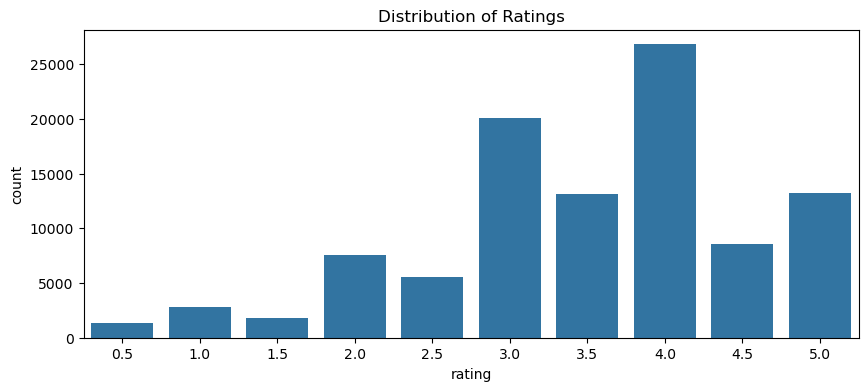

In [13]:
# Distribution of ratings
plt.figure(figsize=(10, 4))
sns.countplot(x='rating', data=merged_df)
plt.title('Distribution of Ratings')
plt.show()

### Interpretation:
Movies are more often rated higher than lower. This means that people more

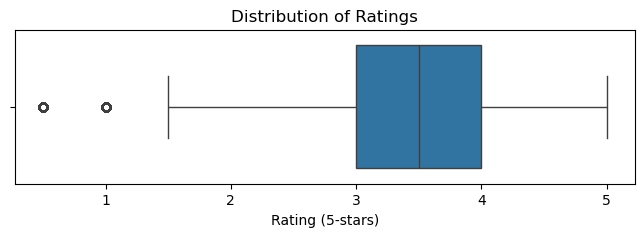

In [14]:
# Boxplot of Movie Ratings
plt.figure(figsize=(8, 2))
sns.boxplot(x='rating', data=merged_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating (5-stars)')
plt.show()

We can confirm that the median for movie ratings is 3.5. Importnat to also note that movies rated 1 and 0.5 are outside the quantile range and considered outliers.

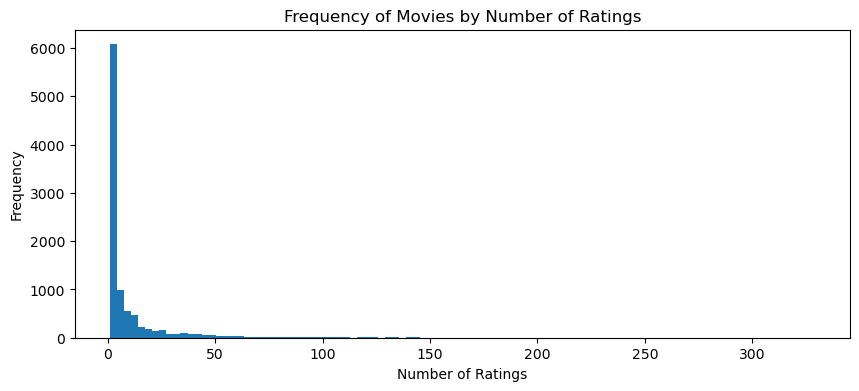

In [15]:
# Number of ratings per movie
ratings_per_movie = merged_df.groupby('movieId')['rating'].count().reset_index()
plt.figure(figsize=(10, 4))
plt.hist(ratings_per_movie['rating'], bins=100)
plt.title('Frequency of Movies by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

### Interpretation

We have many movies with little to no ratings. This means that we have **big** and ***sparse*** data. Keep this in mind for our modeling section. 

In [16]:
!pip install wordcloud -q

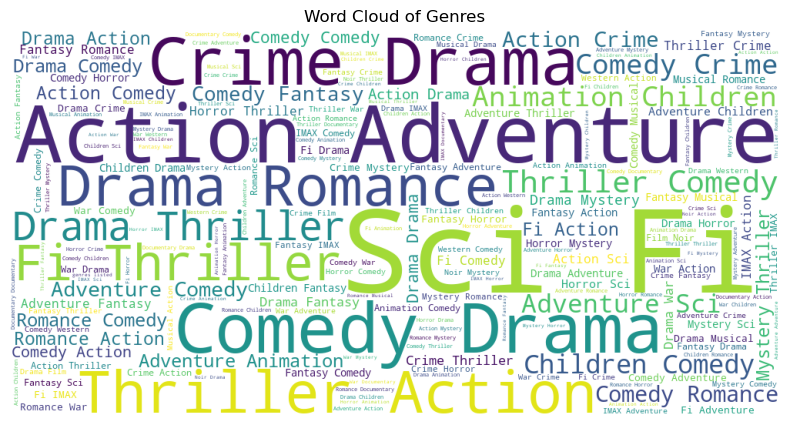

In [17]:
from wordcloud import WordCloud

# Generate Word Cloud of Movie Genres
genre_wc = WordCloud(width=1000, height=500, background_color='white').generate(' '.join(merged_df['genres']))

plt.figure(figsize=(10, 5))
plt.imshow(genre_wc)
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

### Interpretation
Looking at word frequency within ratings and genre we find that Sci-Fi and Action Adventure have high frequencies. Comedy and Drama are also quite notable as well. It is important to look into the number of movies in each genre.

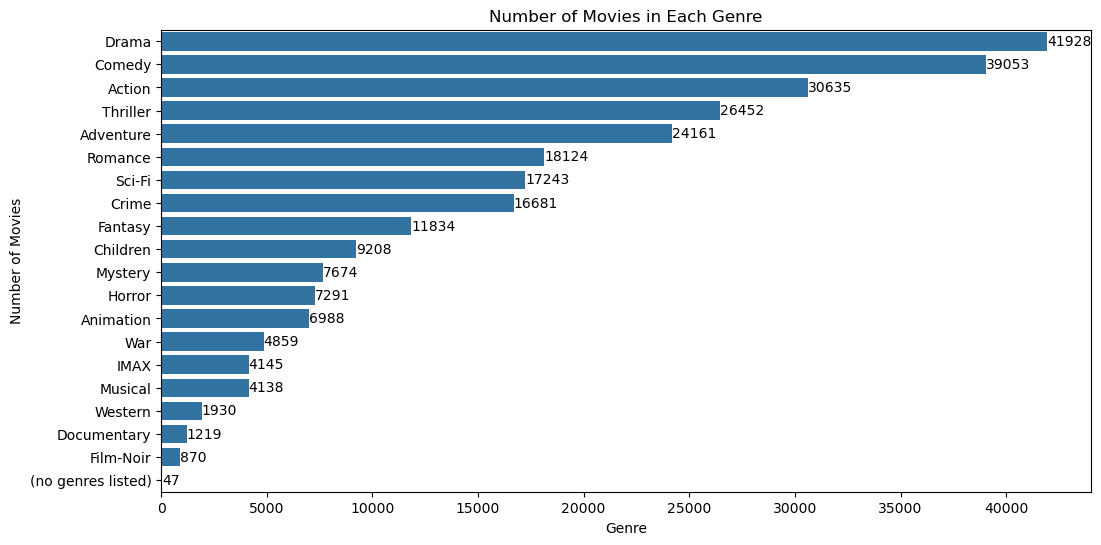

In [18]:
# Split genre and merge
split_genre_count = merged_df['genres'].str.split('|', expand=True).stack().value_counts(ascending=False).to_frame(name='values')
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='values', y=split_genre_count.index, data=split_genre_count, estimator='sum')
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()

### Interpretation
We see that Drama Comedy and Action are the most popular genre for our movies dataset. Sci Fi had come up the largest in our word cloud meaning that Sci Fi must be popular in our ratings dataset. 

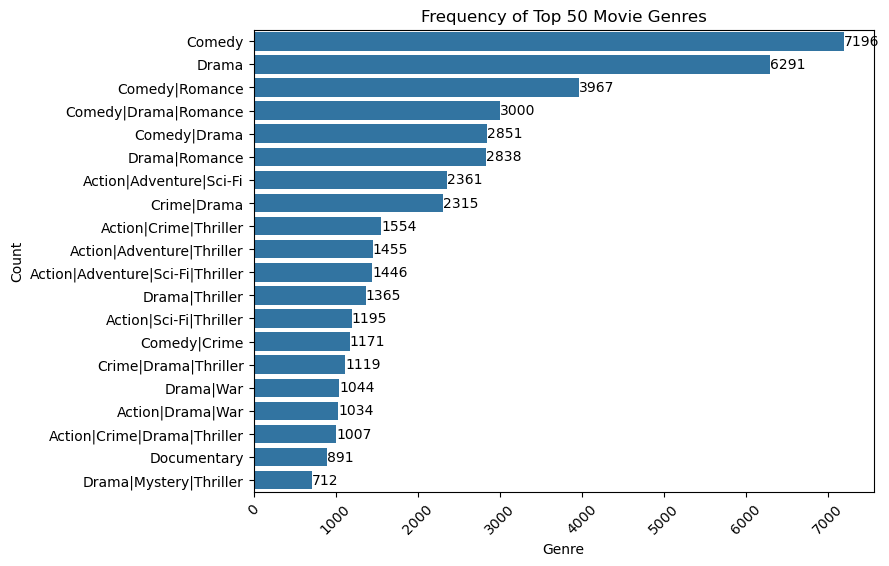

In [19]:
# Creating a lineplot of the 'genre' column
genre_top_20 = merged_df['genres'].value_counts().head(20).to_frame(name='values')

# Plot the lineplot
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(x='values', y=genre_top_20.index, data=genre_top_20, estimator='sum')
ax.bar_label(ax.containers[0], fontsize=10);
plt.xticks(rotation=45)

# Set the axis labels and title
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Frequency of Top 50 Movie Genres')

# Show the plot
plt.show();

### Interpretation
Looking at our each individual genre we now looked at movies combined genres to see what the representation looks like there. We can see that Comedy|Romance and Comedy|Drama are very popular genres in combination with each other.

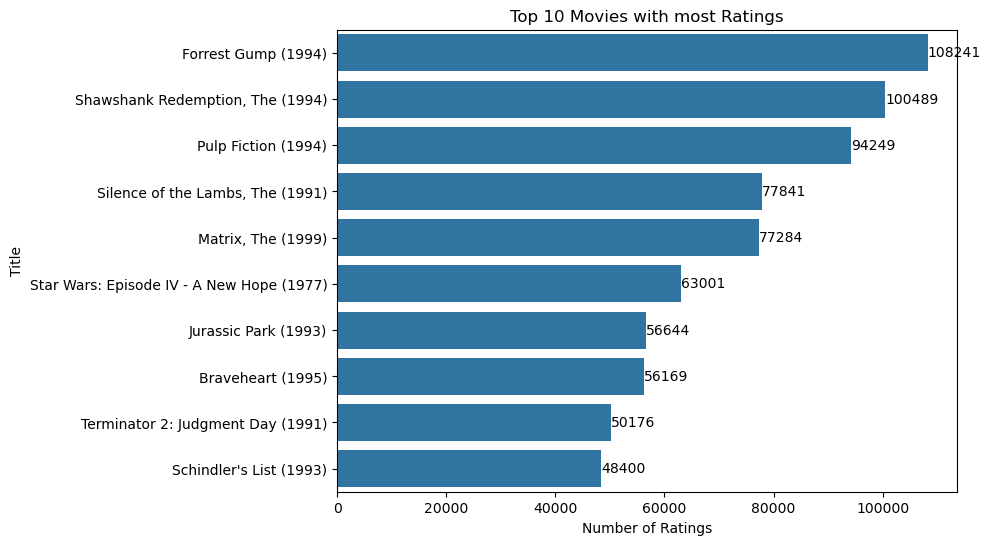

In [20]:
# Get 10 most rated movies in bar chart
top_rated_movies = merged_df.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10).to_frame(name='ratings')
top_rated_movies = pd.merge(top_rated_movies, merged_df[['movieId', 'title']], on='movieId', how='left')
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='ratings', y='title', data=top_rated_movies, estimator='sum')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge');
plt.title('Top 10 Movies with most Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Title')
plt.show()

# Recommendation System
## Why Collaborative Filtering

Collaborative filtering stands out as the popular method for providing online product recommendations. The term "collaborative" stems from its approach of forecasting a particular customer's preferences by analyzing the choices of other customers.

**Pros of Collaborative Filtering:**

1. Personalized Recommendations: Provides personalized suggestions based on user preferences and behaviors.

2. Scalability: Scales well with a growing number of users and items, making it suitable for large datasets.

**Cons of Collaborative Filtering:**

1. Cold Start Problem: Faces challenges when dealing with new users or items with limited historical data, resulting in less accurate recommendations.

2. Sparsity of Data: If the user-item matrix is sparse, meaning there are many missing values, collaborative filtering may struggle to provide accurate recommendations.

## Which Collaborative Filtering
**User-Based Collaborative Filtering:**
Filtering calculates user similarties and relies on similar users to rank movies another user has not.

**Item-Based Collaborative Filtering:**
Filtering calculates item similarities to generate recommendations. Finds similarity between movies and recommends one a user has not ranked.

**-> Memory-Based Approach**

    -> Relies on similarity measures (e.g., cosine similarity or Pearson correlation) to identify users with similar preferences. It then recommends items liked by those similar users or items. We are not learning any parameter using gradient descent such as KNN.

**-> Model-Based Approach**
    
    -> This method employs machine learning algorithms to build predictive models based on user-item interactions. Techniques such as matrix factorization or singular value decomposition fall under this category. Deep learning is also a useful method in classification.

### Start with Memory-Based Approach
We will incorporate a cosine similarity approach. First we have to 

In [21]:
#!pip install surprise

In [22]:
# Import Necessary Packages for Modeling
from surprise import Dataset, Reader, BaselineOnly

import random
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

from surprise.model_selection import train_test_split

from surprise import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import SVD 

from surprise.model_selection import GridSearchCV, cross_validate

from surprise import accuracy

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

### Recommendation with Correlation Matrix
We first will test out recommendations by finding similarities with a users liked movies and other available movies.

In [23]:
#
def interaction_matrix(dataset, userId, title, rating):
    """
    Creates a Matrix of Users rated movies.
    Args:
        dataset(DataFrame Object): Dataframe containing userId, title, and ratings
        userId(int): unique user identifier
        title(object): Title of the movie
        rating(float): rating for movie out of 5-stars
    Returns:
        user_matrx(DataFrame Object): DataFrame of all users and their ratings for
        each movie. Movies unrated are filled with 0's.
    """
    user_matrix = dataset.pivot_table(index = userId, columns = title, values = rating).fillna(0)
    return user_matrix

user_matrix = interaction_matrix(merged_df, 'userId', 'title', 'rating')
user_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
def similar_movies(matrix, movie, title, n):
    """
    Returns n movies with highest correlation to chosen movie.
    Args:
        matrix(DataFrame Object): DataFrame of users and all movie ratings.
        movie(object): string of chosen movie
        title(object): name of column containing movie names
        n(int): number of recommendations
    """
    selected_movie = matrix[movie]
    selected_movie_corr = matrix.corrwith(selected_movie).to_frame(name='Correlation')
    selected_movie_corr.dropna(inplace = True)
    selected_movie_highest_corr = selected_movie_corr.sort_values('Correlation', ascending = False).reset_index()
    movie_rec = list(selected_movie_highest_corr[title][1:n])
    
    return(movie_rec)

In [25]:
# test on Forrest Gump
forrestgump_rec = similar_movies(user_matrix, 'Forrest Gump (1994)', 'title', 10)
print(forrestgump_rec)

['Jurassic Park (1993)', 'Mrs. Doubtfire (1993)', 'Shawshank Redemption, The (1994)', 'Apollo 13 (1995)', 'Pretty Woman (1990)', 'Braveheart (1995)', 'Pulp Fiction (1994)', 'Lion King, The (1994)', 'Speed (1994)']


### Start with Memory-Based Approach
We will incorporate a cosine similarity approach with K Nearest Neighbors.

In [26]:
# 10 obserations of our merged df
merged_df.head(10)

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709.0,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228.0,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,113277.0,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369.0,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814.0,629.0
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,116367.0,755.0
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance,115734.0,13685.0
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War,112573.0,197.0
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War,114287.0,11780.0
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War,109370.0,1775.0


In [27]:
# Pivot the merged df to colelct user ratings per movie title
knn_df = merged_df.pivot_table(index='title',columns='userId',values='rating').fillna(0)
knn_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Create compressed sparse row matrix
movie_features_matrix = csr_matrix(knn_df.values)
# Instantiate NearestNeighbors model with cosine difference
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [29]:
# Reverse map using the pivot matrix
new_indices = {value: index for index, value in enumerate(knn_df.index)}

In [32]:
# Test kneighbors on model to generate recommendations
query_index = new_indices['Matrix, The (1999)']
distances, indices = model_knn.kneighbors(knn_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

# Generate recommendation based on closest distances
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations if you like {knn_df.index[query_index]}:\n')
    else:
        print(f'{i} -> {knn_df.index[indices.flatten()[i]]}, with knn distance of {distances.flatten()[i]:.2f}:')

Recommendations if you like Matrix, The (1999):

1 -> Fight Club (1999), with knn distance of 0.29:
2 -> Star Wars: Episode V - The Empire Strikes Back (1980), with knn distance of 0.30:
3 -> Saving Private Ryan (1998), with knn distance of 0.32:
4 -> Star Wars: Episode IV - A New Hope (1977), with knn distance of 0.34:
5 -> Star Wars: Episode VI - Return of the Jedi (1983), with knn distance of 0.34:


In [33]:
# Create reader class to parse a dataset with user, item, and ratings
reader = Reader(rating_scale=(1, 5))

reader_column_names = ["userId", "movieId", "rating"]

# Load the data into a Surprise Dataset
data_surprise = Dataset.load_from_df(merged_df[reader_column_names], reader)

In [34]:
# cross validating with KNNBase
knn_basic = KNNBasic(sim_options={'name':'cosine', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data_surprise, n_jobs=-1)

# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'cosine', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data_surprise)

# crpss validating with KNNWithMeans
knn_means = KNNWithMeans(sim_options={'name':'cosine', 'user_based':True})
cv_knn_means = cross_validate(knn_means, data_surprise)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [35]:
for i in cv_knn_basic.items():
    print(i)
    
# Print validation results for knn basic
print('-'*30)
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.97579991, 0.9738579 , 0.96591275, 0.976472  , 0.96861353]))
('test_mae', array([0.74887693, 0.74951817, 0.74436151, 0.75466858, 0.74566772]))
('fit_time', (0.06134796142578125, 0.07175803184509277, 0.045082807540893555, 0.048615217208862305, 0.042246341705322266))
('test_time', (0.5367059707641602, 0.5091559886932373, 0.5311331748962402, 0.5176429748535156, 0.5004899501800537))
------------------------------
0.9721312178257374


In [36]:
# Print out the average RMSE and MAE score for the test set
for i in cv_knn_baseline.items():
    print(i)
# Print validation results for knn baseline
print('-'*30)
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.87780329, 0.87555629, 0.87587973, 0.88740661, 0.8683385 ]))
('test_mae', array([0.67250918, 0.67093793, 0.66919994, 0.67704932, 0.66759061]))
('fit_time', (0.09672999382019043, 0.10073375701904297, 0.1116023063659668, 0.13289809226989746, 0.1077580451965332))
('test_time', (0.5856592655181885, 0.5855522155761719, 0.636760950088501, 0.6223788261413574, 0.6772060394287109))
------------------------------
0.8769968847041867


In [37]:
# Print out the average RMSE and MAE score for the test set
for i in cv_knn_means.items():
    print(i)
# print validation results for knn with means
print('-'*30)
print(np.mean(cv_knn_means['test_rmse']))

('test_rmse', array([0.90502318, 0.89906282, 0.89661502, 0.89924961, 0.90543769]))
('test_mae', array([0.69340522, 0.68609239, 0.68409912, 0.68654159, 0.69592319]))
('fit_time', (0.057125091552734375, 0.06052517890930176, 0.05868792533874512, 0.05425214767456055, 0.05891704559326172))
('test_time', (0.5028510093688965, 0.5089290142059326, 0.49121904373168945, 0.5017910003662109, 0.6001441478729248))
------------------------------
0.9010776648105864


In [40]:
def get_title(text, df=merged_df):
    """
    Gets movie title matching a given string.
    Args:
        text('object'): string that matches target movie.
    Returns:
        title('object'): Title of Movie closest to give object
        genre('object'): Genre of Movie
    """
    mask = df['title'].str.contains(text, case=False, regex=False)
    title = df.loc[mask, 'title'].head(1).values[0] if any(mask) else None
    
    if not title:
        print(f"\n'{text}' does not match any movies. Please try again")
        return None, None

    return title, df.loc[mask].head(1)["genres"].values[0]

def knn_get_recs(title, rec=5, verbose=True):
    """Get recommendations for a movie using KNN"""
    # create a return dataframe
    rec_df = pd.DataFrame()
    # initiate an empty list to fill the knn distances
    dists = []
    try:
        # get movie details and the pivot matrix index
        title, genres = get_title(title, merged_df)
        idx = new_indices[title]
        
        # compute the knn distance and index
        distances, knn_indices = model_knn.kneighbors(knn_df.iloc[idx,:].values.reshape(1, -1), n_neighbors = rec + 1)

        if title and verbose:
            print(f'Top Recommendations for {title}:')
            print(f"Chosen Movie Genre: {', '.join(genres.split('|'))}")

        for i in range(0, len(distances.flatten())):
            if i == 0:
                continue
            rec_movie = knn_df.index[knn_indices.flatten()[i]]
            movies_df = data['movies']
            mask = movies_df['title'].str.contains(rec_movie, case=False, regex=False)
            
            # fill in return dataframe
            rec_df = pd.concat([rec_df, movies_df[mask]])
            
            # fill in the knn distances in the df
            dists.append(distances.flatten()[i])

        rec_df["knn_distance"] = dists

        return rec_df

    except Exception as _:
        return "Oh no! Something is wrong!"

In [41]:
knn_get_recs('spider-man', 10)

Top Recommendations for Spider-Man (2002):
Chosen Movie Genre: Action, Adventure, Sci-Fi, Thriller


,movieId,title,genres,knn_distance
5260,8636,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX,0.267842
3832,5378,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX,0.303643
3873,5445,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller,0.338738
4334,6333,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller,0.361211
2836,3793,X-Men (2000),Action|Adventure|Sci-Fi,0.370047
4427,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,0.375362
3638,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,0.379254
4351,6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX,0.387891
4137,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,0.388087
3854,5418,"Bourne Identity, The (2002)",Action|Mystery|Thriller,0.389831


### Recommendation:
- All three KNN-models had very low RMSE which tells us that there is strong accuracy in predicting user ratings.
- The training time for the models is very short and is efficient for further training.
- The KNN-Baseline though marginal did perform the best out of the three. Baseline utilizes a baseline ratings for all users.

Next, let us take a look at SVD and how it will perform on our dataset.

### Try Matrix Factorization with SVD

- A recommendation technique that is efficient when the number of dataset is limited may be unable to generate satisfactory number of recommendations when the volume of dataset is increased.
- Solving scalability problem and speeding up recommendations are because of the methods Dimensionality reduction techniques. Singular Value Decomposition as a method, is able to produce reliable and efficient recommendations at increasing scales.

First we want to find the best parameters for our SVD model.

In [55]:
# generate parameter grid to iterate over in our grid search.
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.4, 0.6]}

# instantiate grid search model
gs_cv = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, joblib_verbose=5)

# fit the model to our surprise data set
gs_cv.fit(data_surprise)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   12.5s finished


In [56]:
# find our best params based on rmse
best_params = gs_cv.best_params["rmse"]
print(best_params)

{'n_factors': 20, 'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.4}


In [57]:
# split our train and test set
trainset, testset = train_test_split(data_surprise, test_size=0.2)

# instantiate SVD model with our best parameters and print accuracy
svd = SVD(**best_params)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8779
0.8779113471544981


The RMSE of our SVD with GridSearchCV is 0.8933 which is very low but performed less than our KNN baseline model but by a small amount. Our dataset is not as large so we should account for the benefit for scalability that SVD has to offer. We must collect more data to see how the model improves.

We have focused on RMSE to evaluate our model performance. The true test is to understand what the actual recommendations are and if the end user will gain a benefit from the recommendations our model provides. 

Let's create a function that recommends n number of movies based on a users past ratings. We will do this by:
1. Create a dictionary of movie ID and title pairs.
2. Build a function that gives us the Anti-Test set for a given user.
3. Generate our final function that gives us the top 10 movies and predicted its predicted ratings.

In [58]:
# create dictionary of movieId and its corresponding title
id_2_names = dict()
movie_df = data['movies']
for idx, names in zip(movie_df['movieId'], movie_df['title']):
    id_2_names[idx] = names

In [59]:
def Build_Anti_Testset4User(userId):
    """
    Return a list of ratings that can be used as a testset. The Anti-Test set
    is all the ratings that are not in the trainset.
    Args: 
        userId(int): users unique identifier
    Returns:
        list of userId and itemIds not used in the trainset.
    """
    fill = trainset.global_mean
    anti_testset = list()
    u = trainset.to_inner_uid(userId)
    
    # ur == users ratings
    user_items = set([item_inner_id for (item_inner_id, rating) in trainset.ur[u]])
    
    anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                            i in trainset.all_items() if i not in user_items]
    
    return anti_testset

# Used insight from this page to build recommendation system.
# https://chicagodatascience.github.io/MLOps/lecture6/mllib/recommendation_system_surpriselib/
def n_top_recs_svd(userId, n_recs=10):
    """
    Return the top-n recommendations for each user from a set of predictions.
    Args:
        userId(int): users unqiue identifier
        n(int): The number of recommendation to output for user. Default
            is 10.
    Returns:
        A dataframe where it contains movies title and ranked ratings of size n.
    """
    testSet = Build_Anti_Testset4User(userId)
    predict = svd.test(testSet)
    
    recommendation = list()
    
    for userID, movieID, actualRating, estimatedRating, _ in predict:
        intMovieID = int(movieID)
        recommendation.append((intMovieID, estimatedRating))
        
    recommendation.sort(key=lambda x: x[1], reverse=True)
    
    movie_names = []
    movie_ratings = []
    
    for name, ratings in recommendation[:20]:
        movie_names.append(id_2_names[name])
        movie_ratings.append(ratings)

    movie_dataframe =  pd.DataFrame({'title': movie_names,
                                      'rating': movie_ratings})
    return movie_dataframe.head(n_recs)

Let's test our function to see what recoommendations they provide for different users!

In [60]:
# test 1
n_top_recs_svd(1, n_recs=10)

,title,rating
0,"Streetcar Named Desire, A (1951)",4.834115
1,"Three Billboards Outside Ebbing, Missouri (2017)",4.762629
2,Guess Who's Coming to Dinner (1967),4.752599
3,Secrets & Lies (1996),4.686097
4,"Hustler, The (1961)",4.680499
5,Ran (1985),4.667332
6,Lawrence of Arabia (1962),4.662736
7,"Day of the Doctor, The (2013)",4.661804
8,Paths of Glory (1957),4.659168
9,"Shawshank Redemption, The (1994)",4.656447


In [49]:
# test 2
n_top_recs_svd(30, n_recs=10)

,title,rating
0,"Three Billboards Outside Ebbing, Missouri (2017)",4.823128
1,"Streetcar Named Desire, A (1951)",4.813928
2,Paths of Glory (1957),4.773460
3,Double Indemnity (1944),4.771409
4,"Shawshank Redemption, The (1994)",4.754994
5,Dr. Strangelove or: How I Learned to Stop Worr...,4.752531
6,Lawrence of Arabia (1962),4.736891
7,His Girl Friday (1940),4.728700
8,"Day of the Doctor, The (2013)",4.724365
9,Guess Who's Coming to Dinner (1967),4.719598


### Conclusion:
In our effort to build a movie reccomendation system, we tested various approaches such as Item-item correlation, Content-Based Filtering using KNN, and a Model-based using SVD. Each approach had its own pros and cons.

Content-Based Filtering: This method suggests movies similar to ones you already like based on their genres. But it might not show you a wide range of options.

Neighborhood-Based Collaborative Filtering (KNN): It finds similar movies by looking at how people interact with them. It's good at spotting patterns but can be slow with lots of data.

Model-Based Collaborative Filtering (SVD): It breaks down your movie preferences into simpler patterns to recommend new movies. It works good even with our smaller dataset. Will be a good choice if we are scaling and increasing our dataset.

### Recommendation:

1. Its important to consider the trade-offs with each approach. I recommend SVD for scalability and or lightFM with more data. By increasing our data SVD will have more scalability and perform with more accuracy. Light FM will give us the option of exploring user metadata. User-item interactions captured by collaborative filtering will provide diverse and personalized recommendations.

2. Next step is to, collect and test on larger dataset, then further hyperparameter tuning and evaluation on our new dataset. We can collect different user meta data to enhance the performance of collaborative filtering techniques. Regular updates to the recommendation engine based on user ratings, metadata and new evolving content can increase its effectiveness over time.

Lastly, let's pickle our model for later use!

In [ ]:
# pickled model
import pickle
with open("recommendation_model_SVD", 'wb') as file:
    pickle.dump(svd, file)

merged_df.to_pickle("SVD_data")